# Snowpylot demo for Western Snow Conference 2025
Demonstrating the functionality of the snowpylot library using snowpits from the 2020-2024 water years


In [1]:
# Import libraries
import os
import pandas as pd
import folium
from folium.plugins import HeatMap
import matplotlib.pyplot as plt
from snowpylot.caaml_parser import caaml_parser

### Set Up

In [2]:
def parse_pits(folder_path):
    """
    Function to parse CAAML files in the specified folder
    """

    files = [
        f for f in os.listdir(folder_path) if f.endswith(".xml")
    ]  # List of all .xml files in the folder

    pits_list = []

    for file in files:  # iterate through each file in the folder
        file_path = folder_path + "/" + file  # create the file path
        pit = caaml_parser(file_path)  # parse the file
        pits_list.append(pit)

    return pits_list

In [3]:
# Define folders and parse pits

pits_19_20 = parse_pits("snowpits/by_season/2019-2020")
pits_20_21 = parse_pits("snowpits/by_season/2020-2021")
pits_21_22 = parse_pits("snowpits/by_season/2021-2022")
pits_22_23 = parse_pits("snowpits/by_season/2022-2023")
pits_23_24 = parse_pits("snowpits/by_season/2023-2024")

all_pits = (
    pits_19_20 + pits_20_21 + pits_21_22 + pits_22_23 + pits_23_24
)  # list of all pits

### Core Info

#### Create DataFrame of Core Info for all Pits

In [4]:
core_info_list = []

for pit in all_pits:
    core_info_dict = {
        # metadata
        "PitID": pit.coreInfo.pitID,
        "Date": pit.coreInfo.date,
        # User
        "SnowPilot Username": pit.coreInfo.user.username,
        "Professional": pit.coreInfo.user.professional,
        "Operation Name": pit.coreInfo.user.operationName,
        # Location
        "Latitude": pit.coreInfo.location.latitude,
        "Longitude": pit.coreInfo.location.longitude,
        "Elevation": pit.coreInfo.location.elevation,
        "Aspect": pit.coreInfo.location.aspect,
        "Slope Angle": pit.coreInfo.location.slopeAngle,
        "Country": pit.coreInfo.location.country,
        "Region": pit.coreInfo.location.region,
        "Pit Near Avalanche": pit.coreInfo.location.pitNearAvalanche,
        "Pit Near Avalanche Location": pit.coreInfo.location.pitNearAvalancheLocation,
    }
    core_info_list.append(core_info_dict)

core_info_df = pd.DataFrame(core_info_list)

In [5]:
# Update country and region for pits with "UT" as country
mask = core_info_df["Country"] == "UT"
core_info_df.loc[mask, "Country"] = "US"
core_info_df.loc[mask, "Region"] = "UT"

#### Create Summary Tables of Core Info

In [6]:
# Create a summary table of core_info_df
core_info_summary = {
    "Total Pits": len(core_info_df),  # Total quantity of PitID
    "Unique Users": core_info_df["SnowPilot Username"].nunique(),  # Unique Usernames
    "Professional Pits": core_info_df[
        "Professional"
    ].sum(),  # Count of Professional = True
    "Non-professional Pits": (
        ~core_info_df["Professional"]
    ).sum(),  # Count of Professional = False
    "Operation with the Most Pits": core_info_df["Operation Name"]
    .value_counts()
    .index[0],
    "Number of Pits Submitted by the CIAC": core_info_df["Operation Name"]
    .value_counts()
    .iloc[0],
}

print("Summary of Pit MetaData:")
for key, value in core_info_summary.items():
    print(key + ":" + str(value))

location_info_summary = {
    "Unique Countries": core_info_df["Country"].nunique(),  # Unique Countries
    "Pits Near an Avalanche": core_info_df[
        "Pit Near Avalanche"
    ].sum(),  # Count of Pit Near Avalanche = True
    "Pits on Avalanche Crown": core_info_df[
        core_info_df["Pit Near Avalanche Location"] == "crown"
    ].shape[0],
    "Pits on Avalanche Flank": core_info_df[
        core_info_df["Pit Near Avalanche Location"] == "flank"
    ].shape[0],
}

print("\nSummary of Location Info:")
for key, value in location_info_summary.items():
    print(key + ":" + str(value))

Summary of Pit MetaData:
Total Pits:31170
Unique Users:3854
Professional Pits:19891
Non-professional Pits:11279
Operation with the Most Pits:Colorado Avalanche Information Center
Number of Pits Submitted by the CIAC:1496

Summary of Location Info:
Unique Countries:30
Pits Near an Avalanche:945
Pits on Avalanche Crown:480
Pits on Avalanche Flank:240


#### Create Pie Chart of Qty Of Snow Pits by Country

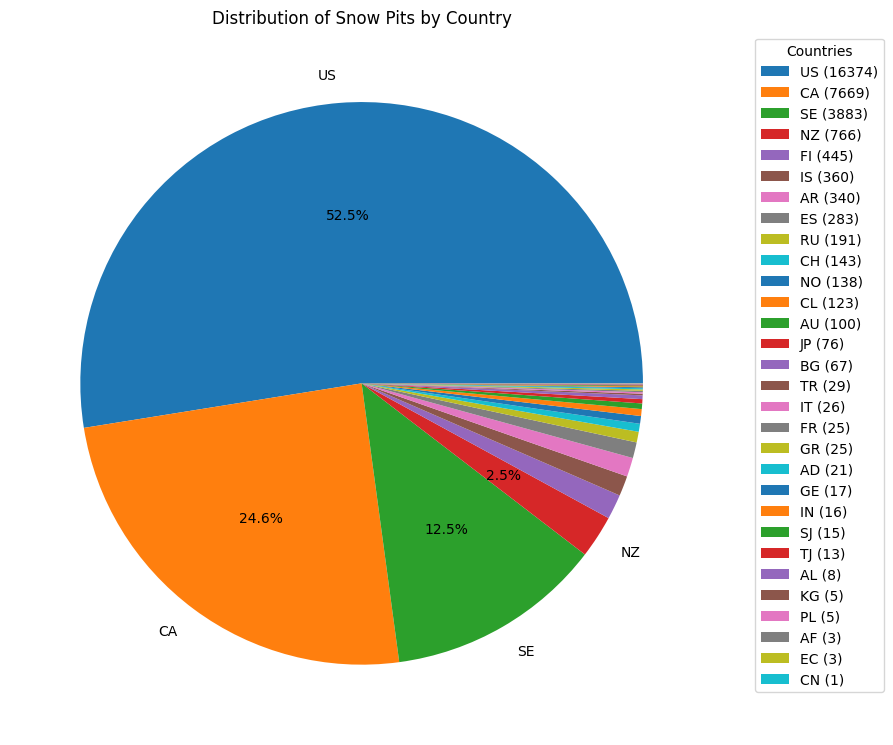

In [7]:
# Create a pie chart of snow pits by country
plt.figure(figsize=(12, 8))

# Get the count of pits by country
country_counts = core_info_df["Country"].value_counts()

# Calculate percentages
total_pits = country_counts.sum()
percentages = (country_counts / total_pits) * 100

# Create lists for labels and values, only including labels for >2%
labels = []
values = []
for country, count in country_counts.items():
    percentage = (count / total_pits) * 100
    if percentage > 2:
        labels.append(country)
    else:
        labels.append("")  # Empty label for small slices
    values.append(count)


# Create a function to format the percentage labels
def make_autopct(values):
    def my_autopct(pct):
        # Only show percentage if it's greater than 2%
        if pct > 2:
            return f"{pct:.1f}%"
        return ""

    return my_autopct


# Create the pie chart
plt.pie(values, labels=labels, autopct=make_autopct(values))

# Add a title
plt.title("Distribution of Snow Pits by Country")

# Add a legend with country codes and counts (including all countries)
plt.legend(
    [
        f"{country} ({count})"
        for country, count in zip(country_counts.index, country_counts.values)
    ],
    title="Countries",
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Display the plot
plt.show()

#### Create Heatmap of Snow Pit Locations in the US

In [8]:
# Filter for US locations only and remove any rows with missing coordinates
us_pits = core_info_df[
    (core_info_df["Country"] == "US")
    & (core_info_df["Latitude"].notna())
    & (core_info_df["Longitude"].notna())
].copy()

# Create a list of locations for the heatmap
locations = us_pits[["Latitude", "Longitude"]].values.tolist()

# Create a base map centered on the US
m = folium.Map(location=[39.8283, -98.5795], zoom_start=4)

# Add the heatmap layer
HeatMap(locations).add_to(m)

# Display the map
m

### Snow Profile

#### Create Dataframe Of SnowProfile Info for All Pits

In [9]:
snow_profile_list = []

for pit in all_pits:
    numPrimaryGrainForm = 0  # initialize
    numPrimaryGrainSize = 0  # initialize
    for layer in pit.snowProfile.layers:  # iterate through each layer in the pit
        if layer.grainFormPrimary is not None:  # if the layer has a primary grain form
            numPrimaryGrainForm += 1  # increment the number of primary grain forms
            if (
                layer.grainFormPrimary.grainSizeAvg is not None
            ):  # if the layer has a primary grain size
                numPrimaryGrainSize += 1  # increment the number of primary grain sizes

    snow_profile_dict = {
        "PitID": pit.coreInfo.pitID,
        "Measurement Direction": pit.snowProfile.measurementDirection,
        "Profile Depth": pit.snowProfile.profileDepth,
        "HS": pit.snowProfile.hS,
        # Surface Conditions
        "Foot Penetration": pit.snowProfile.surfCond.penetrationFoot,
        "Ski Penetration": pit.snowProfile.surfCond.penetrationSki,
        # Layers
        "Num Layers": len(pit.snowProfile.layers),
        "num Layers wPrimary Grain Form": numPrimaryGrainForm,
        "num Layers wPrimary Grain Size": numPrimaryGrainSize,
        # Temp Profile
        "Temp Profile": True if pit.snowProfile.tempProfile is not None else False,
        "Num Temp Obs": len(pit.snowProfile.tempProfile)
        if pit.snowProfile.tempProfile is not None
        else 0,
        # Density Profile
        "Density Profile": True
        if pit.snowProfile.densityProfile is not None
        else False,
        "Num Density Obs": len(pit.snowProfile.densityProfile)
        if pit.snowProfile.densityProfile is not None
        else 0,
    }
    snow_profile_list.append(snow_profile_dict)

snow_profile_df = pd.DataFrame(snow_profile_list)

#### Create Summary Tables of Snow Profile Info

In [10]:
snow_profile_summary = {
    "Total Pits": len(snow_profile_df),
    "Number of Layers": snow_profile_df["Num Layers"].sum(),
    "Number of Layers with Primary Grain Form": snow_profile_df[
        "num Layers wPrimary Grain Form"
    ].sum(),
    "Number of Layers with Primary Grain Size": snow_profile_df[
        "num Layers wPrimary Grain Size"
    ].sum(),
    "Number of Pits with Temperature Profile": snow_profile_df["Temp Profile"].sum(),
    "Number of Temperature Observations": snow_profile_df["Num Temp Obs"].sum(),
    "Number of Pits with Density Profile": snow_profile_df["Density Profile"].sum(),
    "Number of Density Observations": snow_profile_df["Num Density Obs"].sum(),
    "Number of Pits with Foot Penetration": snow_profile_df["Foot Penetration"]
    .notna()
    .sum(),  # Changed to count non-null values
    "Number of Pits with Ski Penetration": snow_profile_df["Ski Penetration"]
    .notna()
    .sum(),  # Changed to count non-null values
}

print("Summary of Snow Profile Info:")
for key, value in snow_profile_summary.items():
    print(key + ":" + str(value))

Summary of Snow Profile Info:
Total Pits:31170
Number of Layers:232718
Number of Layers with Primary Grain Form:190805
Number of Layers with Primary Grain Size:109034
Number of Pits with Temperature Profile:14449
Number of Temperature Observations:134518
Number of Pits with Density Profile:891
Number of Density Observations:7731
Number of Pits with Foot Penetration:19811
Number of Pits with Ski Penetration:11061


### Stability Tests

#### Create Dataframe of Stability Test Info for All Pits

In [11]:
stability_tests_list = []

for pit in all_pits:
    stability_tests_dict = {
        # metadata
        "PitID": pit.coreInfo.pitID,
        "Num ECT": len(pit.stabilityTests.ECT),
        "Num CT": len(pit.stabilityTests.CT),
        "Num RBlock": len(pit.stabilityTests.RBlock),
        "Num PST": len(pit.stabilityTests.PST),
    }
    stability_tests_list.append(stability_tests_dict)

stability_tests_df = pd.DataFrame(stability_tests_list)

#### Create Summary Tables

In [12]:
# Summary of Stability Test Info

# Totals
total_pits = len(stability_tests_df)
total_w_stab_results = stability_tests_df[
    (stability_tests_df["Num ECT"] > 0)
    | (stability_tests_df["Num CT"] > 0)
    | (stability_tests_df["Num PST"] > 0)
    | (stability_tests_df["Num RBlock"] > 0)
].shape[0]
percent_w_stab_results = total_w_stab_results / total_pits

stability_tests_summary = {
    "Total Pits": total_pits,
    "Total Pits with Stability Test Results": total_w_stab_results,
    "Percentage of Pits with Stability Test Results": "%.2f%%"
    % (percent_w_stab_results * 100),
}

print("Summary of Overall Available Test Info")
for key, value in stability_tests_summary.items():
    print(key + ":" + str(value))

Summary of Overall Available Test Info
Total Pits:31170
Total Pits with Stability Test Results:28151
Percentage of Pits with Stability Test Results:90.31%


In [13]:
# Summary of Specific Test Info
specific_test_info = {
    # ECT
    "Total Pits with ECT Results": (stability_tests_df["Num ECT"] > 0).sum(),
    "Total ECT Results": stability_tests_df["Num ECT"].sum(),
    "Percentage of Pits with ECT Results": "%.2f%%"
    % ((((stability_tests_df["Num ECT"] > 0).sum()) / total_pits) * 100),
    # CT
    "Total Pits with CT Results": (stability_tests_df["Num CT"] > 0).sum(),
    "Total CT Results": stability_tests_df["Num CT"].sum(),
    "Percentage of Pits with CT Results": "%.2f%%"
    % ((((stability_tests_df["Num CT"] > 0).sum()) / total_pits) * 100),
    # PST
    "Total Pits with PST Results": (stability_tests_df["Num PST"] > 0).sum(),
    "Total PST Results": stability_tests_df["Num PST"].sum(),
    "Percentage of Pits with PST Results": "%.2f%%"
    % ((((stability_tests_df["Num PST"] > 0).sum()) / total_pits) * 100),
    # RBlock
    "Total Pits with RBlock Results": (stability_tests_df["Num RBlock"] > 0).sum(),
    "Total RBlock Results": stability_tests_df["Num RBlock"].sum(),
    "Percentage of Pits with RBlock Results": "%.2f%%"
    % ((((stability_tests_df["Num RBlock"] > 0).sum()) / total_pits) * 100),
}

for key, value in specific_test_info.items():
    print(key + ":" + str(value))

Total Pits with ECT Results:21092
Total ECT Results:29247
Percentage of Pits with ECT Results:67.67%
Total Pits with CT Results:18022
Total CT Results:32150
Percentage of Pits with CT Results:57.82%
Total Pits with PST Results:3102
Total PST Results:3719
Percentage of Pits with PST Results:9.95%
Total Pits with RBlock Results:121
Total RBlock Results:134
Percentage of Pits with RBlock Results:0.39%


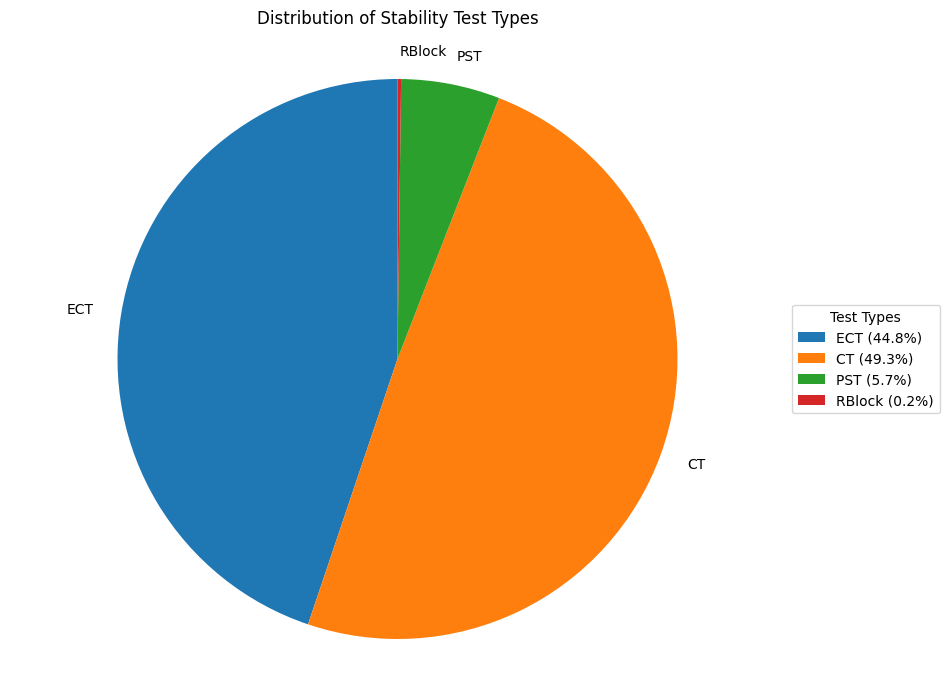

In [14]:
# Calculate total number of each test type and reorder to put RBlock last
test_counts = {
    "ECT": stability_tests_df["Num ECT"].sum(),
    "CT": stability_tests_df["Num CT"].sum(),
    "PST": stability_tests_df["Num PST"].sum(),
    "RBlock": stability_tests_df["Num RBlock"].sum(),
}

# Reorder the dictionary to put RBlock last
ordered_test_counts = {
    "ECT": test_counts["ECT"],
    "CT": test_counts["CT"],
    "PST": test_counts["PST"],
    "RBlock": test_counts["RBlock"],
}

# Calculate percentages
total_tests = sum(ordered_test_counts.values())
percentages = {k: (v / total_tests) * 100 for k, v in ordered_test_counts.items()}

# Create simple labels for pie chart
pie_labels = list(ordered_test_counts.keys())

# Create detailed labels with percentages for legend
legend_labels = [f"{k} ({v:.1f}%)" for k, v in percentages.items()]

# Create pie chart
plt.figure(figsize=(10, 8))
plt.pie(ordered_test_counts.values(), labels=pie_labels, startangle=90)
plt.title(
    "Distribution of Stability Test Types", pad=20
)  # Added padding to move title up
plt.axis("equal")  # Equal aspect ratio ensures that pie is drawn as a circle

# Add a legend
plt.legend(
    legend_labels, title="Test Types", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1)
)

plt.show()

### Example Analysis

#### Primary Grain Class vs Hand Hardness

#### RQ2

**Research Question 2**

How often is a Q1 fracture associated with an ECTP on the same layer?

In [15]:
pits_with_CT_ECT = []

for pit in all_pits:
    if len(pit.stabilityTests.CT) > 0 and len(pit.stabilityTests.ECT) > 0:
        pits_with_CT_ECT.append(pit)


print(len(pits_with_CT_ECT))  ## How many pits have CT and ECT results?



11137


In [16]:
# ECT and CT results

results_list = []
results_dict = {}

for pit in pits_with_CT_ECT:
    ECTs = pit.stabilityTests.ECT
    CTs = pit.stabilityTests.CT

    for ect in ECTs:
        for ct in CTs:  # Every combination of ECT and CT results
            if (
                ect.depthTop == ct.depthTop and ect.propogation == True
            ):  # If failure on the same level and ECT has propogation
                results_dict = {
                    "PitID": pit.coreInfo.pitID,
                    "ECT Score": ect.testScore,
                    "CT Shear Qual": ct.fractureCharacter,
                }
                results_list.append(results_dict)

df = pd.DataFrame(results_list)
grouped = df.groupby("PitID")
print(grouped.sum())

df = df.drop_duplicates(
    subset=["PitID"], keep="first"
)  # Drop duplicates per pit NOTE This keeps the first occurance, update?
print("Unique df")
print(df)

          ECT Score CT Shear Qual
PitID                            
12803        ECTP23            RP
17362    ECTPVECTPV          SPSP
17411        ECTP14            SP
17441    ECTP4ECTP4          RPRP
17490        ECTP10            SP
...             ...           ...
69235        ECTP25             0
73897  ECTP14ECTP14          SPSP
74318  ECTP25ECTP25          SCSC
74594        ECTP14            RP
75250         ECTP1            SP

[2749 rows x 2 columns]
Unique df
      PitID ECT Score CT Shear Qual
0     12803    ECTP23            RP
1     17362     ECTPV            SP
3     17411    ECTP14            SP
4     17441     ECTP4            RP
6     17490    ECTP10            SP
...     ...       ...           ...
3559  66221    ECTP28            SP
3560  69234    ECTP16            SC
3561  69235    ECTP25          None
3562  74318    ECTP25            SC
3564  75250     ECTP1            SP

[2749 rows x 3 columns]


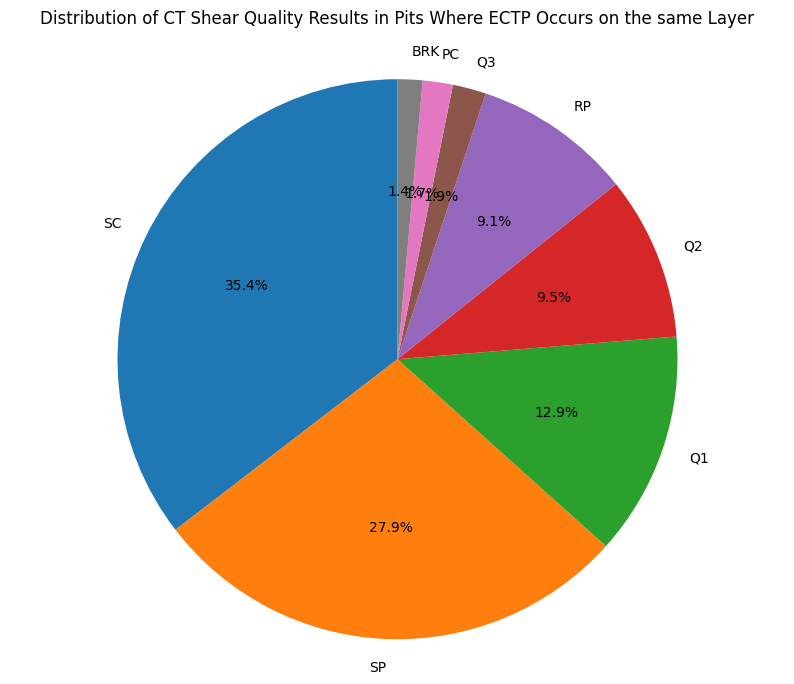


Shear Quality Distribution:
CT Shear Qual
SC     937
SP     739
Q1     342
Q2     250
RP     242
Q3      51
PC      46
BRK     38
Name: count, dtype: int64

Percentages:
CT Shear Qual
SC     34.1
SP     26.9
Q1     12.4
Q2      9.1
RP      8.8
Q3      1.9
PC      1.7
BRK     1.4
Name: count, dtype: float64


In [17]:
# Calculate value counts for ShearQual
shear_counts = df["CT Shear Qual"].value_counts()

# Create pie chart
plt.figure(figsize=(10, 8))
plt.pie(
    shear_counts.values,
    labels=shear_counts.index,
    autopct="%1.1f%%",  # Show percentages with 1 decimal place
    startangle=90,
)  # Rotate start of pie to 90 degrees

# Add title
plt.title(
    "Distribution of CT Shear Quality Results in Pits Where ECTP Occurs on the same Layer",
    pad=20,
)

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis("equal")

# Show the plot
plt.show()

# Optional: Print the actual counts and percentages
print("\nShear Quality Distribution:")
print(shear_counts)
print("\nPercentages:")
print((shear_counts / len(df["CT Shear Qual"]) * 100).round(1))

Try Treemap grouped by "Q"